# rosita

*rosita* is a fork of a subset of librosa. The idea behind it is to access some of the well tested functionality without including all dependencies that librosa has. In particular librosa depends on numba, which poses clear problems regarding numpy and in the end limits the python version for the entire project. *rosita* extracts just some of the algorithms plus the needed utility functions and keeps all names and arguments, so that it can be a drop-in replacement. At the moment *rosita* is included in *maelzel*, but it might be ported out as an independent project in the future. 


In [1]:
from maelzel.snd import audiosample
from maelzel.snd import rosita
import matplotlib.pyplot as plt
import csoundengine as ce
import numpy as np

plt.rcParams["figure.figsize"] = (21,8)

In [2]:
s = audiosample.Sample("../snd/onset-detection-test.flac", end=17.5)
s.samples

array([0., 0., 0., ..., 0., 0., 0.], shape=(771750,))

Sample(dur=17.5, sr=44100, ch=1)
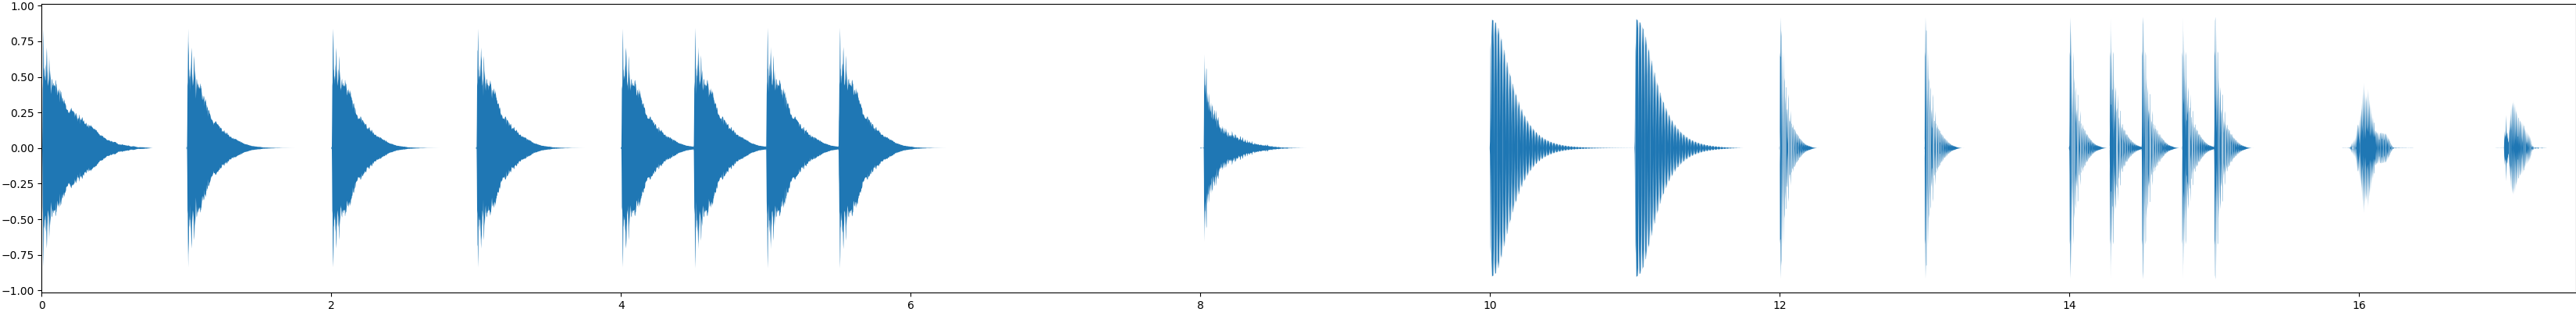

In [3]:
s

## Onset Detection

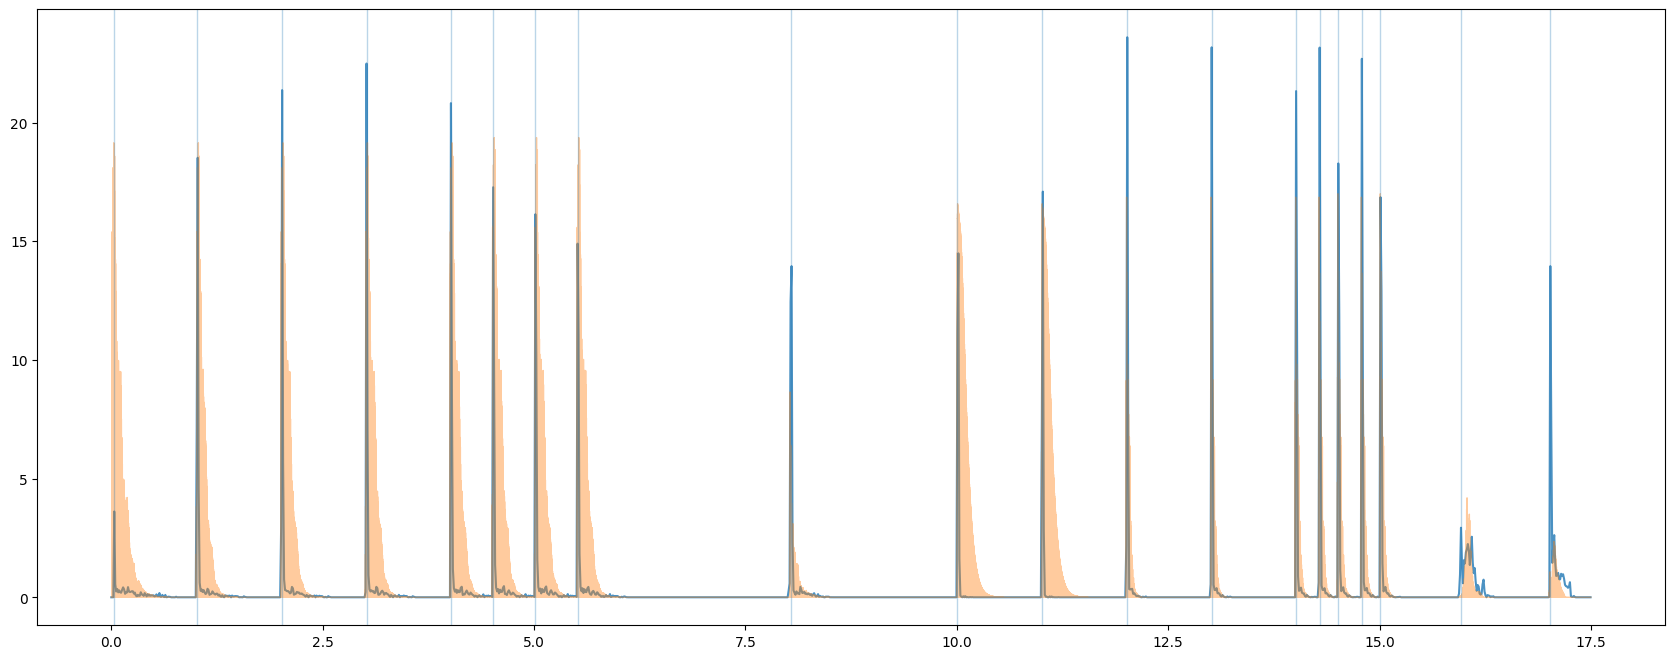

In [4]:
hop = 512
env = rosita.onset_strength(y=s.samples, sr=s.sr, hop_length=hop)
envtimes = rosita.times_like(env, sr=s.sr, hop_length=hop)
onsets = rosita.onset_detect(s.samples, s.sr, onset_envelope=env, hop_length=hop, units='time', delta=0.07, mingap=0.15)

plt.plot(envtimes, env, alpha=0.8)
plt.plot(np.arange(0, s.duration, 1/s.sr), s.samples**2*20, alpha=0.4, linewidth=1)
for onset in onsets:
    plt.axvline(x=onset, alpha=0.3, linewidth=1)

In [5]:
import csoundengine as ce
# e = ce.OfflineEngine()
e = ce.Engine()
e.compile(r'''
instr click
  pset 0, 0, 0, 0.5
  iamp = p4
  a0 = oscili(iamp, 1000) * expseg:a(0.00001, 0.005, 1, 0.1, 0.0001)
  outch 1, a0
endin
''')

using libsndfile-1.2.2
sr = 48000.0, kr = 750.000, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
reading 2048-byte blks of shorts from adc:Built-in Audio Analog Stereo: (RAW)
writing 512 sample blks of 64-bit floats to dac:Built-in Audio Analog Stereo:
SECTION 1:


In [6]:
for onset in onsets:
    e.sched('click', delay=onset, dur=0.05)


In [7]:
import csoundengine.offlineengine

e = csoundengine.offlineengine.OfflineEngine()
tab = e.makeTable(s.samples, sr=s.sr)
e.playSample(tabnum=tab, delay=1)


--Csound version 7.0 (double samples) Oct 28 2025
[commit: 15afda0ba81a895a4e87ac3ef5fe476702b072bf]
using libsndfile-1.2.2
sr = 44100.0, kr = 689.062, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
writing 1024-byte blks of shorts to /tmp/csoundengine-yet45i8m.wav (WAV)
SECTION 1:


18.0002

resetting Csound instance
		   overall amps:  0.98401  0.00000
	   overall samples out of range:        0        0
0 errors in performance
512 1024 sample blks of shorts written to /tmp/csoundengine-yet45i8m.wav (WAV)


RenderJob(outfile='/tmp/csoundengine-yet45i8m.wav', samplerate=44100, encoding='float32', starttime=0.0, endtime=0.0, process=None)
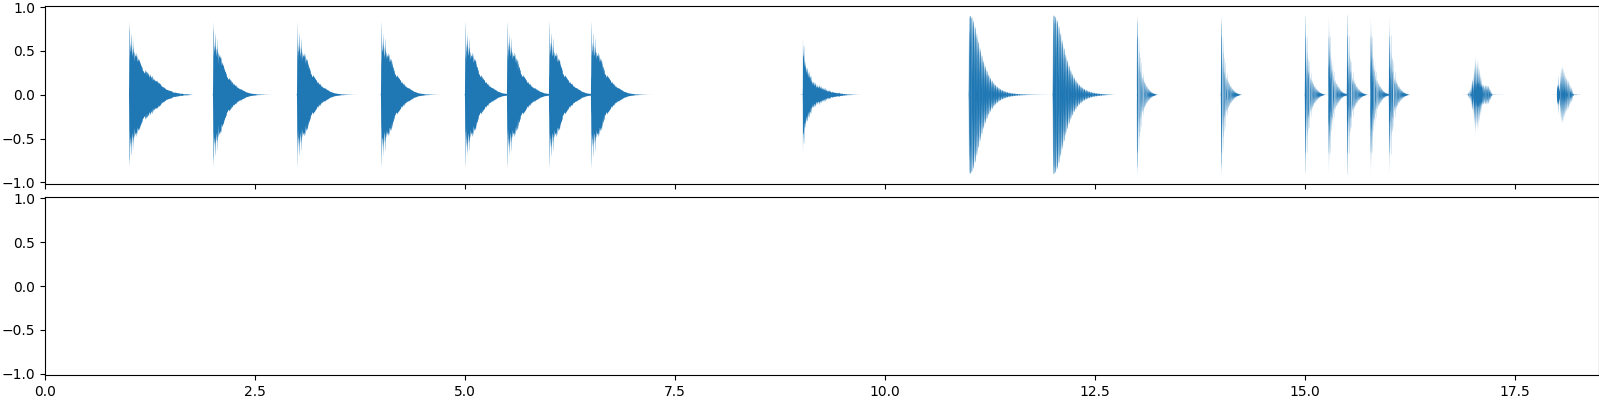

In [8]:
e.stop()

In [11]:
from csoundengine.offline import OfflineSession
session = OfflineSession()
session.defInstr('click', r'''
|iamp=0.5|
a0 = oscili(iamp, 1000) * expseg:a(0.00001, 0.005, 1, 0.1, 0.0001)
outch 1, a0
''')

Instr(click, iamp=0.5)

RenderJob(outfile='/home/em/dev/python/maelzel/notebooks/test/onset-test.flac', samplerate=44100, encoding='pcm24', starttime=0.0, endtime=0.0, process=<Popen: returncode: 0 args: ['/usr/local/bin/csound', '-o', '/home/em/dev/py...>)
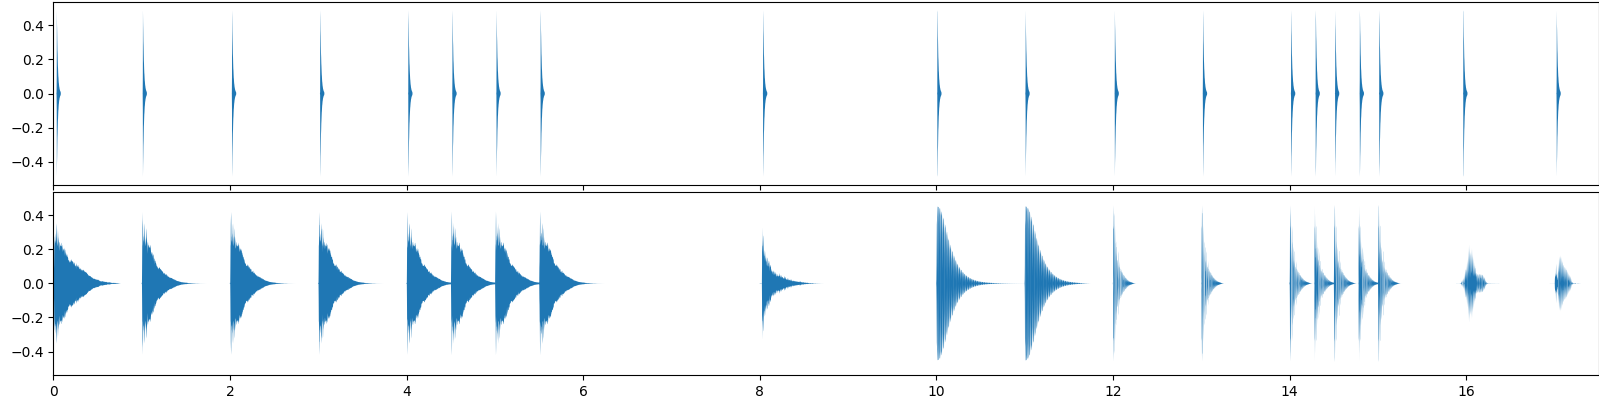

In [12]:
for onset in onsets:
    session.sched('click', delay=onset, dur=0.05)
session.playSample((s.samples, s.sr), pan=1, gain=0.5)
session.render("onset-test.flac", verbose=False)

## Test pyin

In [13]:
from maelzel.snd import rosita
from maelzel.snd import audiosample
import numpy as np
s = audiosample.Sample("../snd/voiceover-fragment-48k.flac")

In [14]:
f0, voicedflag, voicedprob = rosita.pyin(s.samples, sr=s.sr, fmin=50, fmax=3000, frame_length=2048, hop_length=512)
times = np.arange(len(f0)) * (512 / s.sr)

In [16]:
from csoundengine.offline import OfflineSession
session = OfflineSession()

session.defInstr('vco', r'''
|kfreq=1000|
outch 1, vco2:a(0.1, kfreq)
''')


Instr(vco, kfreq=1000)

In [17]:
sy = session.sched('vco')
sy.automate('kfreq', (times, f0))

0

In [18]:
import maelzel.snd.vamptools as vt
track = vt.pyinPitchTrack(s.samples, s.sr)

LibXtract compiled with ooura FFT


mnOut size: 1674
m_pitchTrack size: 1674


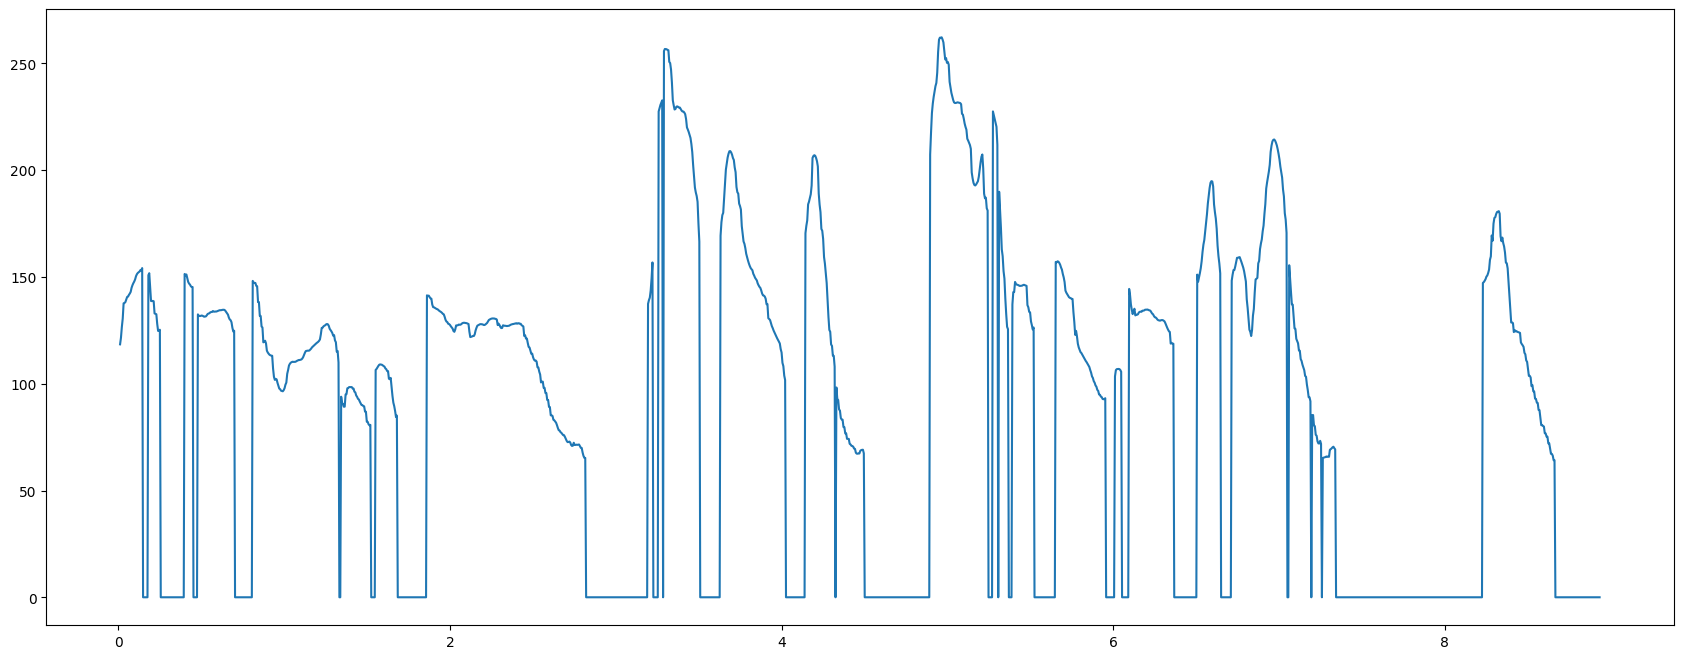

In [19]:
vampfreqs = track[:,1]
vampfreqs[vampfreqs < 50] = 0.1
plt.plot(track[:,0], track[:,1])

In [20]:
sy = session.sched('vco')
sy.automate('kfreq', (track[:,0], vampfreqs))

0

In [21]:
sy

SchedEvent(p1=50.0002, start=0.0, dur=-1.0, uniqueId=1, args=[-1, 1000.0], instrname=vco, priority=1)